In [550]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from scipy.optimize import minimize
import pandas as pd
from scipy.stats import poisson, uniform, expon, pareto
from tqdm import tqdm
from mdptoolbox import mdp, util
import itertools
from scipy.sparse import csr_matrix, lil_matrix
from matplotlib.patches import Patch
import math
import random
import sympy as sp
from sympy.printing.latex import print_latex

# Simulations & Theory for fixed block rewards under \beta cutoff strategy

In [551]:
# simluation code
def simAllRews(a, b, p, C, E, n):
    gamma = 0
    state = [0,0] # (attacker, honest)

    honestBlcs = 0
    attackBlcs = 0
    honestRews = 0
    attackRews = 0
    honestBern = 0
    attackBern = 0
    curTime    = 0
    lastState0 = 0
    lastAttBlc = 0
    prevBern   = 0
    for _ in range(n):
        attBlock = np.random.binomial(1, a)
        execRews = np.random.exponential()
        bernRews = np.random.binomial(1, p=p)
        curTime += execRews

        if state == [0,0]:
            if attBlock:
                if bernRews and execRews < (b-C-E):
                    state      = [1,0]
                    lastAttBlc = curTime
                    prevBern   = bernRews
                elif not bernRews and execRews < b-C:
                    state      = [1,0]
                    lastAttBlc = curTime
                    prevBern   = 0
                else:
                    attackBlcs += 1*C
                    attackRews += execRews
                    attackBern += bernRews
                    lastState0  = curTime
                    lastAttBlc  = curTime
            else:
                honestBlcs += 1*C
                honestRews += execRews
                honestBern += bernRews
                lastState0  = curTime
                lastAttBlc  = curTime
            continue

        if state == [1,0]:
            if attBlock:
                state = [2,0]
                lastAttBlc = curTime
                attackBern += bernRews + prevBern
                prevBern   = 0
            else:
                sample        = np.random.uniform()
                nextExecRews  = np.random.exponential()
                nextBern      = np.random.binomial(1, p=p)
                if sample < a:
                    attackBlcs += 2*C
                    attackRews += (curTime - lastState0) + nextExecRews
                    attackBern += (prevBern + nextBern)
                elif sample <= a + ((1-a)*gamma):
                    attackBlcs += 1*C
                    honestBlcs += 1*C
                    attackRews += (lastAttBlc - lastState0)
                    honestRews += (curTime - lastAttBlc) + nextExecRews
                    attackBern += prevBern
                    honestBern += nextBern
                else:
                    honestBlcs += 2*C
                    honestRews += (curTime - lastState0) + nextExecRews
                    # honest bern is a random trial
                    prevHonest  = np.random.binomial(1, p=p)
                    honestBern += (prevHonest + nextBern)
                curTime    += nextExecRews
                lastState0  = curTime
                lastAttBlc  = curTime
                prevBern    = 0
                state = [0,0]
            continue

        if attBlock:
            state[0] += 1
            lastAttBlc = curTime
        else:
            state[1] += 1

        diff = state[0] - state[1]
        if diff == 1:
            attackBlcs += state[0]*C
            if state[0] < 2:
                raise KeyError("here")
            attackBern += (state[0]-2) * p * E
            attackRews += (lastAttBlc - lastState0)

            # 0'' state
            remRews = (curTime - lastAttBlc)
            attBlock = np.random.binomial(1, a)
            execRews = np.random.exponential()
            bernRews = np.random.binomial(1, p=p)
            curTime += execRews
            if attBlock:
                attackBlcs += 1*C
                attackRews += (remRews + execRews)
                attackBern += bernRews
            else:
                honestBlcs += 1*C
                honestRews += (remRews + execRews)
                honestBern += bernRews

            lastState0  = curTime
            lastAttBlc  = curTime
            state = [0,0]
 
    return honestBlcs, attackBlcs, honestBern, attackBern, honestRews, attackRews

In [552]:
alphas    = [0.2, 0.25, 0.3, 0.35, 0.4]
betas     = np.arange(1.751, 4, 0.01)
ps        = [0.25, 0.5, 0.75] # using E=1, C=1
sim_betas = np.arange(1.751, 4.1, 0.125)
sim_betas

array([1.751, 1.876, 2.001, 2.126, 2.251, 2.376, 2.501, 2.626, 2.751,
       2.876, 3.001, 3.126, 3.251, 3.376, 3.501, 3.626, 3.751, 3.876,
       4.001])

In [554]:
sim_res_fixed = []
sim_res_bern  = []
sim_res_lin   = []
for a in alphas:
    temp1_fixed = []
    temp1_bern  = []
    temp1_lin  = []
    for b in tqdm(sim_betas):
        temp2_fixed = []
        temp2_bern  = []
        temp2_lin  = []
        for p in ps:
            honestBlc, attackBlc, honestBer, attackBer, honestLin, attackLin = simAllRews(
                a=a, b=b, p=p, C=1, E=1, n=int(1e6))
            temp2_fixed.append(attackBlc/(attackBlc+honestBlc))
            temp2_bern.append(attackBer/(attackBer+honestBer))
            temp2_lin.append(attackLin/(attackLin+honestLin))
        temp1_fixed.append(temp2_fixed)
        temp1_bern.append(temp2_bern)
        temp1_lin.append(temp2_lin)
    sim_res_fixed.append(temp1_fixed)
    sim_res_bern.append(temp1_bern)
    sim_res_lin.append(temp1_lin)
sim_res_fixed = np.array(sim_res_fixed)
sim_res_bern = np.array(sim_res_bern)
sim_res_lin = np.array(sim_res_lin)
sim_res_fixed.shape, sim_res_bern.shape, sim_res_lin.shape

100%|██████████| 19/19 [05:34<00:00, 17.61s/it]


((5, 19, 3), (5, 19, 3), (5, 19, 3))

# Theoretical for fixed rewards

In [564]:
p0, p0p, p1, p0pp = sp.symbols('p_0 p_{00} p_1 p_{000}')
a, b, x, g, p, C, E  = sp.symbols('a b x g p C E')

In [565]:
# p_i is the stationary distribution for State i
p0    = p1 / (a*(1-p)*(1-sp.exp(-b+C)) + a*p*(1-sp.Min(sp.exp(-b+C+E),1)))
p0p   = p1 * (1-a)
p0pp  = p1 * a
p2    = p1*(a/(1-a))
prest = p1*a/(1-2*a)

In [566]:
eq = sp.Eq(p0+p0p+p0pp+prest+p1, 1)
p1_sym = sp.solve(eq, p1)[0]

In [567]:
p1_me = (1/(a*(1-p)*(1-sp.exp(-b+C)) + a*p*(1-sp.Min(sp.exp(-b+C+E),1))) + 1 + (1-a)/(1-2*a))**(-1)
p1_me

1/(1 + 1/(a*p*(1 - Min(1, exp(C + E - b))) + a*(1 - p)*(1 - exp(C - b))) + (1 - a)/(1 - 2*a))

In [568]:
# confirming the symbolic solver and my by hand solver have same values
p1_sym.evalf(subs={a:0.3, b:3, p:0.5, C:1, E:1}), p1_me.evalf(subs={a:0.3, b:3, p:0.5, C:1, E:1})

(0.138811963706275, 0.138811963706275)

In [569]:
# 3 cases for f0
f0i_fixed   = C * (a*p*sp.Min(1,sp.exp(-b+C+E)) + a*(1-p)*sp.exp(-b+C))
f0ii_fixed  = a*C * (a*p*(1-sp.Min(1,sp.exp(-b+C+E))) + a*(1-p)*(1-sp.exp(-b+C)))
f0iii_fixed = (1-a)*(a+g*(1-a))*C * (a*p*(1-sp.Min(1,sp.exp(-b+C+E))) + a*(1-p)*(1-sp.exp(-b+C)))
f0iii_fixed

C*(1 - a)*(a + g*(1 - a))*(a*p*(1 - Min(1, exp(C + E - b))) + a*(1 - p)*(1 - exp(C - b)))

In [570]:
# explicit for f0 and f1
f0_fixed   = f0i_fixed + f0ii_fixed + f0iii_fixed
f1_fixed   = C*(a+(1-a)*a)
f0_fixed

C*a*(a*p*(1 - Min(1, exp(C + E - b))) + a*(1 - p)*(1 - exp(C - b))) + C*(1 - a)*(a + g*(1 - a))*(a*p*(1 - Min(1, exp(C + E - b))) + a*(1 - p)*(1 - exp(C - b))) + C*(a*p*Min(1, exp(C + E - b)) + a*(1 - p)*exp(C - b))

In [571]:
attacker_full_fixed  = p0*f0_fixed + p1*f1_fixed + C*p1*a*(2*a*(1-a)/(1-2*a))
p1_ev = p1_sym.evalf(subs={C:1., E:1.})
attacker_final_fixed = sp.simplify(attacker_full_fixed.evalf(subs={p1:p1_ev, C:1., E:1., g:0}))
attacker_final_fixed

a*(0.245252960780962*a**2*(a - 1.0)*(p*(Min(1.0, 7.38905609893065*exp(-b)) - 1.0)*exp(b) + (p - 1.0)*(1.0*exp(b) - 2.71828182845905)) - 0.122626480390481*a*(a - 2.0)*(2.0*a - 1.0)*(p*(Min(1.0, 7.38905609893065*exp(-b)) - 1.0)*exp(b) + (p - 1.0)*(1.0*exp(b) - 2.71828182845905)) - 0.122626480390481*(2.0*a - 1.0)*(1.0*a*(a - 1.0)*(p*(Min(1.0, 7.38905609893065*exp(-b)) - 1.0)*exp(b) + (p - 1.0)*(1.0*exp(b) - 2.71828182845905)) - 1.0*a*(p*(Min(1.0, 7.38905609893065*exp(-b)) - 1.0)*exp(b) + (p - 1.0)*(1.0*exp(b) - 2.71828182845905)) + 1.0*p*exp(b)*Min(1.0, 7.38905609893065*exp(-b)) - 2.71828182845905*p + 2.71828182845905))*(-5.43656365691809*a*p + 5.43656365691809*a + 2.71828182845905*p + (2.0*a*p*Min(1.0, 7.38905609893065*exp(-b)) - 2.0*a - p*Min(1.0, 7.38905609893065*exp(-b)) + 1.0)*exp(b) - 2.71828182845905)/((2.0*a - 1.0)*(p*(Min(1.0, 7.38905609893065*exp(-b)) - 1.0)*exp(b) + (p - 1.0)*(1.0*exp(b) - 2.71828182845905))*(-a**2*p + a**2 + 0.666666666666667*a*p - 0.666666666666667*a + 0.1226

In [572]:
attacker_final_fixed_lambda = sp.lambdify((a, b, p), attacker_final_fixed)
attacker_final_fixed_lambda

<function _lambdifygenerated(a, b, p)>

In [573]:
g0_fixed   = C*(1-a)
g1_fixed   = C*(1-a)*(1-a)*(1-g)
g0p_fixed  = C*(1-a)
g0pp_fixed = C*(1-a)

In [574]:
honest_full_fixed = p0*g0_fixed + p1*g1_fixed + p0p*g0p_fixed + p0pp*g0pp_fixed
honest_final_fixed = honest_full_fixed.evalf(subs={p1:p1_ev, C:1., E:1., g:0})
honest_final_fixed

1.0*a**2*(1.0 - a)*(-2.0*a*p*Min(1.0, 7.38905609893065*exp(-b)) + 5.43656365691809*a*p*exp(-b) + 2.0*a - 5.43656365691809*a*exp(-b) + p*Min(1.0, 7.38905609893065*exp(-b)) - 2.71828182845905*p*exp(-b) - 1.0 + 2.71828182845905*exp(-b))/(-3.0*a**2*p*Min(1.0, 7.38905609893065*exp(-b)) + 8.15484548537714*a**2*p*exp(-b) + 3.0*a**2 - 8.15484548537714*a**2*exp(-b) + 2.0*a*p*Min(1.0, 7.38905609893065*exp(-b)) - 5.43656365691809*a*p*exp(-b) + 5.43656365691809*a*exp(-b) - 1.0) + 2.0*a*(1.0 - a)**2*(-2.0*a*p*Min(1.0, 7.38905609893065*exp(-b)) + 5.43656365691809*a*p*exp(-b) + 2.0*a - 5.43656365691809*a*exp(-b) + p*Min(1.0, 7.38905609893065*exp(-b)) - 2.71828182845905*p*exp(-b) - 1.0 + 2.71828182845905*exp(-b))/(-3.0*a**2*p*Min(1.0, 7.38905609893065*exp(-b)) + 8.15484548537714*a**2*p*exp(-b) + 3.0*a**2 - 8.15484548537714*a**2*exp(-b) + 2.0*a*p*Min(1.0, 7.38905609893065*exp(-b)) - 5.43656365691809*a*p*exp(-b) + 5.43656365691809*a*exp(-b) - 1.0) + 1.0*a*(1.0 - a)*(-2.0*a*p*Min(1.0, 7.38905609893065*ex

In [575]:
honest_final_fixed_lambda = sp.lambdify((a, b, p), honest_final_fixed)
honest_final_fixed_lambda

<function _lambdifygenerated(a, b, p)>

In [161]:
theo_res_fixed = []
for a_ in alphas:
    temp1 = []
    for b_ in betas:
        temp2 = []
        for p_ in ps:
            attack = attacker_final_fixed_lambda(a=a_, b=b_, p=p_)
            honest = honest_final_fixed_lambda(a=a_, b=b_, p=p_)
            temp2.append(attack/(attack+honest))
        temp1.append(temp2)
    theo_res_fixed.append(temp1)
theo_res_fixed = np.array(theo_res_fixed)
theo_res_fixed.shape

(5, 225, 3)

# Theoretical for Bernoulli rewards

In [576]:
f0i_bern   = E * (a*p*sp.Min(1,sp.exp(-b+C+E)))
f0ii_bern  = a*E * (a*p*(1-sp.Min(1,sp.exp(-b+C+E))))
f0iii_bern = (1-a)*(a+g*(1-a))*E * (a*p*(1-sp.Min(1,sp.exp(-b+C+E))))
f0iii_bern

E*a*p*(1 - a)*(1 - Min(1, exp(C + E - b)))*(a + g*(1 - a))

In [577]:
f0_bern   = f0i_bern + f0ii_bern + f0iii_bern
f1_bern   = p*E*(a+(1-a)*a)

In [578]:
attack_full_bern  = p0*f0_bern + p1*f1_bern + p*E*p1*a*(2*a*(1-a)/(1-2*a))
p1_ev = p1_sym.evalf(subs={C:1., E:1.})
attack_final_bern = sp.simplify(attack_full_bern.evalf(subs={p1:p1_ev, C:1., E:1., g:0}))
attack_final_bern

a*p*(0.245252960780962*a**2*(a - 1.0)*(p*(Min(1.0, 7.38905609893065*exp(-b)) - 1.0)*exp(b) + (p - 1.0)*(1.0*exp(b) - 2.71828182845905)) - 0.122626480390481*a*(a - 2.0)*(2.0*a - 1.0)*(p*(Min(1.0, 7.38905609893065*exp(-b)) - 1.0)*exp(b) + (p - 1.0)*(1.0*exp(b) - 2.71828182845905)) - 0.122626480390481*(2.0*a - 1.0)*(a*(a - 1.0)*(Min(1.0, 7.38905609893065*exp(-b)) - 1.0) - a*(Min(1.0, 7.38905609893065*exp(-b)) - 1.0) + Min(1.0, 7.38905609893065*exp(-b)))*exp(b))*(-5.43656365691809*a*p + 5.43656365691809*a + 2.71828182845905*p + (2.0*a*p*Min(1.0, 7.38905609893065*exp(-b)) - 2.0*a - p*Min(1.0, 7.38905609893065*exp(-b)) + 1.0)*exp(b) - 2.71828182845905)/((2.0*a - 1.0)*(p*(Min(1.0, 7.38905609893065*exp(-b)) - 1.0)*exp(b) + (p - 1.0)*(1.0*exp(b) - 2.71828182845905))*(-a**2*p + a**2 + 0.666666666666667*a*p - 0.666666666666667*a + 0.122626480390481*(3.0*a**2*p*Min(1.0, 7.38905609893065*exp(-b)) - 3.0*a**2 - 2.0*a*p*Min(1.0, 7.38905609893065*exp(-b)) + 1.0)*exp(b)))

In [579]:
attack_final_bern_lambda = sp.lambdify((a, b, p), attack_final_bern)
attack_final_bern_lambda

<function _lambdifygenerated(a, b, p)>

In [580]:
g0_bern   = p*E*(1-a)
g1_bern   = p*E*(1-a)*(1-a)*(1-g)
g0p_bern  = p*E*(1-a)
g0pp_bern = p*E*(1-a)

In [581]:
honest_full_bern = p0*g0_bern + p1*g1_bern + p0p*g0p_bern + p0pp*g0pp_bern
honest_final_bern = honest_full_bern.evalf(subs={p1:p1_ev, C:1., E:1., g:0})
honest_final_bern

1.0*a**2*p*(1.0 - a)*(-2.0*a*p*Min(1.0, 7.38905609893065*exp(-b)) + 5.43656365691809*a*p*exp(-b) + 2.0*a - 5.43656365691809*a*exp(-b) + p*Min(1.0, 7.38905609893065*exp(-b)) - 2.71828182845905*p*exp(-b) - 1.0 + 2.71828182845905*exp(-b))/(-3.0*a**2*p*Min(1.0, 7.38905609893065*exp(-b)) + 8.15484548537714*a**2*p*exp(-b) + 3.0*a**2 - 8.15484548537714*a**2*exp(-b) + 2.0*a*p*Min(1.0, 7.38905609893065*exp(-b)) - 5.43656365691809*a*p*exp(-b) + 5.43656365691809*a*exp(-b) - 1.0) + 2.0*a*p*(1.0 - a)**2*(-2.0*a*p*Min(1.0, 7.38905609893065*exp(-b)) + 5.43656365691809*a*p*exp(-b) + 2.0*a - 5.43656365691809*a*exp(-b) + p*Min(1.0, 7.38905609893065*exp(-b)) - 2.71828182845905*p*exp(-b) - 1.0 + 2.71828182845905*exp(-b))/(-3.0*a**2*p*Min(1.0, 7.38905609893065*exp(-b)) + 8.15484548537714*a**2*p*exp(-b) + 3.0*a**2 - 8.15484548537714*a**2*exp(-b) + 2.0*a*p*Min(1.0, 7.38905609893065*exp(-b)) - 5.43656365691809*a*p*exp(-b) + 5.43656365691809*a*exp(-b) - 1.0) + 1.0*a*p*(1.0 - a)*(-2.0*a*p*Min(1.0, 7.38905609893

In [582]:
honest_final_bern_lambda = sp.lambdify((a, b, p), honest_final_bern)
honest_final_bern_lambda

<function _lambdifygenerated(a, b, p)>

In [169]:
theo_res_bern = []
for a_ in alphas:
    temp1 = []
    for b_ in betas:
        temp2 = []
        for p_ in ps:
            attack = attack_final_bern_lambda(a=a_, b=b_, p=p_)
            honest = honest_final_bern_lambda(a=a_, b=b_, p=p_)
            temp2.append(attack/(attack+honest))
        temp1.append(temp2)
    theo_res_bern.append(temp1)
theo_res_bern = np.array(theo_res_bern)
theo_res_bern.shape

(5, 225, 3)

# Theoretical for linear rewards

In [583]:
f0i_lin   = a*p*(b-C-E+1)*sp.exp(-b+C+E) + a*(1-p)*(b-C+1)*sp.exp(-b+C)
f0ii_lin  = a* (a*p*(1-(b-C-E+1)*sp.exp(-b+C+E)) + a*(1-p)*(1-(b-C+1)*sp.exp(-b+C))) 
f0iii_lin = ((1-a)*(a+g*(1-a)))* (a*p*(1-(b-C-E+1)*sp.exp(-b+C+E)) + a*(1-p)*(1-(b-C+1)*sp.exp(-b+C)))
f0iii_lin

(1 - a)*(a + g*(1 - a))*(a*p*(-(-C - E + b + 1)*exp(C + E - b) + 1) + a*(1 - p)*(-(-C + b + 1)*exp(C - b) + 1))

In [584]:
f0_lin = f0i_lin + f0ii_lin + f0iii_lin
f1_lin = a + 2*a*(1-a)

In [585]:
attack_full_lin = p0*f0_lin + p1*f1_lin + p1*a*a*(3-2*a)/(1-2*a)
p1_ev = p1_sym.evalf(subs={C:1., E:1.})
attack_final_lin = sp.simplify(attack_full_lin.evalf(subs={p1:p1_ev, C:1., E:1., g:0}))
attack_final_lin

0.122626480390481*a*(a**2*(2.0*a - 3.0)*(p*(Min(1.0, 7.38905609893065*exp(-b)) - 1.0)*exp(b) + (p - 1.0)*(1.0*exp(b) - 2.71828182845905)) - a*(2.0*a - 3.0)*(2.0*a - 1.0)*(p*(Min(1.0, 7.38905609893065*exp(-b)) - 1.0)*exp(b) + (p - 1.0)*(1.0*exp(b) - 2.71828182845905)) + (2.0*a - 1.0)*(-a*(a - 1.0)*(p*(7.38905609893065*b - 1.0*exp(b) - 7.38905609893065) - (2.71828182845905*b - 1.0*exp(b))*(p - 1.0)) + a*(p*(7.38905609893065*b - 1.0*exp(b) - 7.38905609893065) - (2.71828182845905*b - 1.0*exp(b))*(p - 1.0)) + 2.71828182845905*b*(p - 1.0) - 7.38905609893065*p*(b - 1.0)))*(-5.43656365691809*a*p + 5.43656365691809*a + 2.71828182845905*p + (2.0*a*p*Min(1.0, 7.38905609893065*exp(-b)) - 2.0*a - p*Min(1.0, 7.38905609893065*exp(-b)) + 1.0)*exp(b) - 2.71828182845905)/((2.0*a - 1.0)*(p*(Min(1.0, 7.38905609893065*exp(-b)) - 1.0)*exp(b) + (p - 1.0)*(1.0*exp(b) - 2.71828182845905))*(-a**2*p + a**2 + 0.666666666666667*a*p - 0.666666666666667*a + 0.122626480390481*(3.0*a**2*p*Min(1.0, 7.38905609893065*exp

In [586]:
attack_final_lin_lambda = sp.lambdify((a, b, p), attack_final_lin)
attack_final_lin_lambda

<function _lambdifygenerated(a, b, p)>

In [174]:
theo_res_lin = []
for a_ in alphas:
    temp1 = []
    for b_ in betas:
        temp2 = []
        for p_ in ps:
            attack = attack_final_lin_lambda(a=a_, b=b_, p=p_)
            temp2.append(attack)
        temp1.append(temp2)
    theo_res_lin.append(temp1)
theo_res_lin = np.array(theo_res_lin)
theo_res_lin.shape

(5, 225, 3)

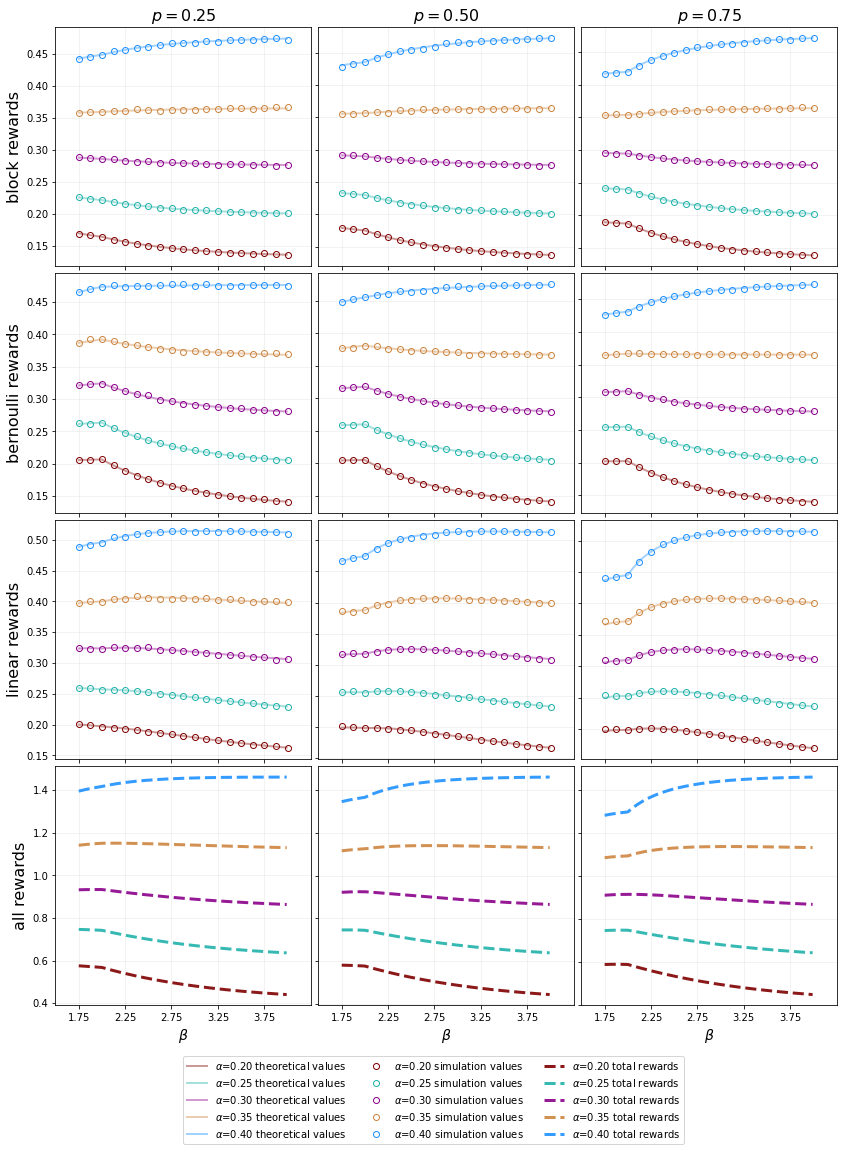

In [555]:
f, axarr = plt.subplots(nrows=4, ncols=3, figsize=(14,18))

colors = ['maroon', 'lightseagreen', 'darkmagenta', 'peru', 'dodgerblue'] 
handles, labels = [], []

for i in range(3):
    ax = axarr[0,i]
    for j, a_ in enumerate(alphas):
        line, = ax.plot(betas, theo_res_fixed[j,:,i], linewidth=2, color=colors[j], alpha=0.4,
                        label=r'$\alpha$={:0.2f} theoretical values'.format(a_))
        if i == 0:
            handles.append(line)
            labels.append(r'$\alpha$={:0.2f} theoretical values'.format(a_))
    ax = axarr[1,i]
    for j, a_ in enumerate(alphas):
        line, = ax.plot(betas, theo_res_bern[j,:,i], linewidth=2, color=colors[j], alpha=0.4,
                        label=r'$\alpha$={:0.2f} theoretical values'.format(a_))
    ax = axarr[2,i]
    for j, a_ in enumerate(alphas):
        line, = ax.plot(betas, theo_res_lin[j,:,i], linewidth=2, color=colors[j], alpha=0.4,
                        label=r'$\alpha$={:0.2f} theoretical values'.format(a_))

for i in range(3):
    ax = axarr[0,i]
    for j, a_ in enumerate(alphas):
        marker, = ax.plot(sim_betas, sim_res_fixed[j,:,i], marker='o', color=colors[j], linestyle='none', 
                          fillstyle='none', label=r'$\alpha$={:0.2f} simulation values'.format(a_))
        if i == 0:
            handles.append(marker)
            labels.append(r'$\alpha$={:0.2f} simulation values'.format(a_))
    ax = axarr[1,i]
    for j, a_ in enumerate(alphas):
        marker, = ax.plot(sim_betas, sim_res_bern[j,:,i], marker='o', color=colors[j], linestyle='none', 
                          fillstyle='none', label=r'$\alpha$={:0.2f} simulation values'.format(a_))
    ax = axarr[2,i]
    for j, a_ in enumerate(alphas):
        marker, = ax.plot(sim_betas, sim_res_lin[j,:,i], marker='o', color=colors[j], linestyle='none', 
                          fillstyle='none', label=r'$\alpha$={:0.2f} simulation values'.format(a_))

for i in range(3):
    ax = axarr[3,i]
    for j, a_ in enumerate(alphas):
        all_rews = theo_res_fixed[j,:,i] + theo_res_bern[j,:,i] + theo_res_lin[j,:,i]
        line, = ax.plot(betas, all_rews, linewidth=3, color=colors[j], alpha=0.9, linestyle='--',
                       label=r'$\alpha$={:0.2f} total rewards'.format(a_))
        if i == 0:
            handles.append(line)
            labels.append(r'$\alpha$={:0.2f} total rewards'.format(a_))

        
for i, ax in enumerate(axarr.flatten()):
    ax.grid(alpha=0.2)
    ax.set_xlim(1.5, 4.25)
    ax.set_xticks(np.arange(1.75,4.01,0.5))
    

f.subplots_adjust(wspace=0.03, hspace=0.03)


for i, ax in enumerate(axarr[0]):
    ax.set_yticks(np.arange(0.15,0.451,0.05))
    ax.set_title(r'$p={:0.2f}$'.format(ps[i]), size=16)
    
for i, ax in enumerate(axarr[1]):
    ax.set_yticks(np.arange(0.15,0.451,0.05))

for i, ax in enumerate(axarr[3]):
    ax.set_xlabel(r'$\beta$', size=14)
    
for i in range(4):
    axarr[i,1].set_yticklabels([])
    axarr[i,2].set_yticklabels([])
#     axarr[i,1].set_xticklabels([])
#     axarr[i,2].set_xticklabels([])

axarr[0,0].set_ylabel(r'block rewards', size=16)
axarr[1,0].set_ylabel(r'bernoulli rewards', size=16)
axarr[2,0].set_ylabel(r'linear rewards', size=16)
axarr[3,0].set_ylabel(r'all rewards', size=16)
f.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.09), ncol=3)

plt.savefig('out.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

# optimal betas with both types of rewards

In [243]:
honest_final_fixed   = honest_full_fixed.evalf(subs={p1:p1_ev, E:1.})
attacker_final_fixed = attacker_full_fixed.evalf(subs={p1:p1_ev, E:1.})
attack_final_lin     = attack_full_lin.evalf(subs={p1:p1_ev, E:1.})

In [246]:
honest_final_fixed_lambda   = sp.lambdify((a, b, p, g, C), honest_final_fixed)
attacker_final_fixed_lambda = sp.lambdify((a, b, p, g, C), attacker_final_fixed)
attack_final_lin_lambda     = sp.lambdify((a, b, p, g, C), attack_final_lin)
attack_final_lin_lambda

<function _lambdifygenerated(a, b, p, g, C)>

In [274]:
def LinRewards(a_, b_, p_, g_, C_):
    return attack_final_lin_lambda(a_, b_, p_, g_, C_)

def LinAndBlockRewards(a_, b_, p_, g_, C_):
    lin  = attack_final_lin_lambda(a_, b_, p_, g_, C_)
    a_fixed = attacker_final_fixed_lambda(a_, b_, p_, g_, C_)
    h_fixed = honest_final_fixed_lambda(a_, b_, p_, g_, C_)
    return lin + a_fixed/(a_fixed+h_fixed)

In [292]:
alphas = np.arange(0.01, 0.5, 0.01)
betas  = np.arange(1.01, 8.1, 0.01)
p_     = float(1e-16)
gammas = [0., 0.25, 0.5]

opt_beta_linear = []
opt_beta_total  = []
for g_ in gammas:
    temp1, temp2 = [], []
    for a_ in tqdm(alphas):
        fulls = [LinAndBlockRewards(a_=a_, b_=b_, p_=p_, g_=g_, C_=1.) for b_ in betas]
        lins  = [LinRewards(a_=a_, b_=b_, p_=p_, g_=g_, C_=1.) for b_ in betas]
        temp1.append(betas[np.argmax(fulls)])
        temp2.append(betas[np.argmax(lins)])
    opt_beta_total.append(temp1)
    opt_beta_linear.append(temp2)
opt_beta_total  = np.array(opt_beta_total)
opt_beta_linear = np.array(opt_beta_linear)
opt_beta_linear.shape, opt_beta_total.shape

100%|██████████| 49/49 [00:16<00:00,  2.96it/s]


((3, 49), (3, 49))

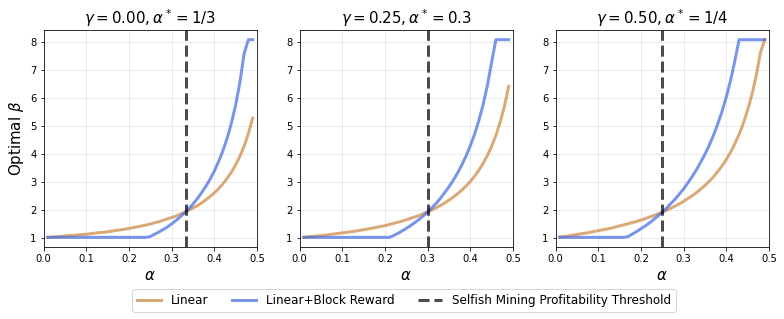

In [300]:
f, axarr = plt.subplots(ncols=3, figsize=(13,4))
for i in range(3):
    axarr[i].plot(alphas, opt_beta_linear[i], label=r'Linear', color='peru', 
                  linestyle='-', linewidth=3, alpha=0.7) 
    axarr[i].plot(alphas, opt_beta_total[i], label=r'Linear+Block Reward', color='royalblue', 
                  linestyle='-', linewidth=3, alpha=0.7)

for ax in axarr:
    ax.grid(alpha=0.3)
    ax.set_xlabel(r'$\alpha$', size=15)
    ax.set_xlim(0,0.5)
    
axarr[0].set_ylabel(r'Optimal $\beta$', size=15)
axarr[0].set_title(r'$\gamma=0.00, \alpha^*=1/3$', size=15)
axarr[1].set_title(r'$\gamma=0.25, \alpha^*=0.3$', size=15)
axarr[2].set_title(r'$\gamma=0.50, \alpha^*=1/4$', size=15)

axarr[0].axvline(1/3, color='k', linewidth=3, alpha=0.7, linestyle='--', label='Selfish Mining Profitability Threshold')
axarr[1].axvline(0.3, color='k', linewidth=3, alpha=0.7, linestyle='--')
axarr[2].axvline(1/4, color='k', linewidth=3, alpha=0.7, linestyle='--')


handles, labels = axarr[0].get_legend_handles_labels()
f.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.51, -0.12), ncol=3, fontsize=12)

plt.savefig('out.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

# Threshold alphas

In [587]:
attack_full_lin

a**2*p_1*(3 - 2*a)/(1 - 2*a) + p_1*(2*a*(1 - a) + a) + p_1*(a*p*(-C - E + b + 1)*exp(C + E - b) + a*(1 - p)*(-C + b + 1)*exp(C - b) + a*(a*p*(-(-C - E + b + 1)*exp(C + E - b) + 1) + a*(1 - p)*(-(-C + b + 1)*exp(C - b) + 1)) + (1 - a)*(a + g*(1 - a))*(a*p*(-(-C - E + b + 1)*exp(C + E - b) + 1) + a*(1 - p)*(-(-C + b + 1)*exp(C - b) + 1)))/(a*p*(1 - Min(1, exp(C + E - b))) + a*(1 - p)*(1 - exp(C - b)))

In [493]:
honest_final_fixed   = honest_full_fixed.evalf(subs={p1:p1_ev, E:1.})
attacker_final_fixed = attacker_full_fixed.evalf(subs={p1:p1_ev, E:1.})
honest_final_bern    = honest_full_bern.evalf(subs={p1:p1_ev, E:1.})
attack_final_bern    = attack_full_bern.evalf(subs={p1:p1_ev, E:1.})
attack_final_lin     = attack_full_lin.evalf(subs={p1:p1_ev, E:1.})

In [494]:
honest_final_fixed_lambda   = sp.lambdify((a, b, p, g, C), honest_final_fixed)
attacker_final_fixed_lambda = sp.lambdify((a, b, p, g, C), attacker_final_fixed)
honest_final_bern_lambda    = sp.lambdify((a, b, p, g, C), honest_final_bern)
attacker_final_bern_lambda  = sp.lambdify((a, b, p, g, C), attacker_final_bern)
attack_final_lin_lambda     = sp.lambdify((a, b, p, g, C), attack_final_lin)
attack_final_lin_lambda

<function _lambdifygenerated(a, b, p, g, C)>

In [495]:
def BlockRewards(a_, b_, p_, g_, C_):
    a_fixed = attacker_final_fixed_lambda(a_, b_, p_, g_, C_)
    h_fixed = honest_final_fixed_lambda(a_, b_, p_, g_, C_)
    return a_fixed/(a_fixed+h_fixed)

def LinRewards(a_, b_, p_, g_, C_):
    return attack_final_lin_lambda(a_, b_, p_, g_, C_)

def LinAndBlockRewards(a_, b_, p_, g_, C_):
    lin  = attack_final_lin_lambda(a_, b_, p_, g_, C_)
    a_fixed = attacker_final_fixed_lambda(a_, b_, p_, g_, C_)
    h_fixed = honest_final_fixed_lambda(a_, b_, p_, g_, C_)
    return lin + a_fixed/(a_fixed+h_fixed)

def FullRewards(a_, b_, p_, g_, C_):
    lin  = attack_final_lin_lambda(a_, b_, p_, g_, C_)
    a_fixed = attacker_final_fixed_lambda(a_, b_, p_, g_, C_)
    h_fixed = honest_final_fixed_lambda(a_, b_, p_, g_, C_)
    a_bern  = attacker_final_bern_lambda(a_, b_, p_, g_, C_)
    h_bern  = honest_final_bern_lambda(a_, b_, p_, g_, C_)
    return (lin + a_fixed/(a_fixed+h_fixed) + a_bern/(a_bern+h_bern))/3

In [545]:
gammas = np.arange(0.01, 1, 0.01)
alphas = np.arange(0.01, 0.50, 0.005)
betas = np.arange(1.01, 5.01, 0.05)
p_ = 0.5
C_ = 1.

In [422]:
FullRewards(a_, bestBeta, p_, g_, C_)

0.19648202274333584

In [546]:
b_res  = []
for g_ in tqdm(gammas):
    for a_ in alphas:
        bs = [BlockRewards(a_, b_, p_, g_, C_) for b_ in betas]
        bestBeta = betas[np.argmax(bs)]
        if FullRewards(a_, bestBeta, p_, g_, C_) > a_:
            b_res.append(a_)
            break        
b_res = np.array(b_res)
b_res.shape

100%|██████████| 99/99 [01:31<00:00,  1.08it/s]


(99,)

In [547]:
l_res  = []
for g_ in tqdm(gammas):
    for a_ in alphas:
        bs = [LinRewards(a_, b_, p_, g_, C_) for b_ in betas]
        bestBeta = betas[np.argmax(bs)]
        if FullRewards(a_, bestBeta, p_, g_, C_) > a_:
            l_res.append(a_)
            break        
l_res = np.array(l_res)
l_res.shape

100%|██████████| 99/99 [00:36<00:00,  2.73it/s]


(99,)

In [548]:
f_res = []
for g_ in tqdm(gammas):
    for a_ in alphas:
        bs = [FullRewards(a_, b_, p_, g_, C_) for b_ in betas]
        bestBeta = betas[np.argmax(bs)]
        if FullRewards(a_, bestBeta, p_, g_, C_) > a_:
            f_res.append(a_)
            break        
f_res = np.array(bl_res)
f_res.shape

100%|██████████| 99/99 [02:38<00:00,  1.60s/it]


(99,)

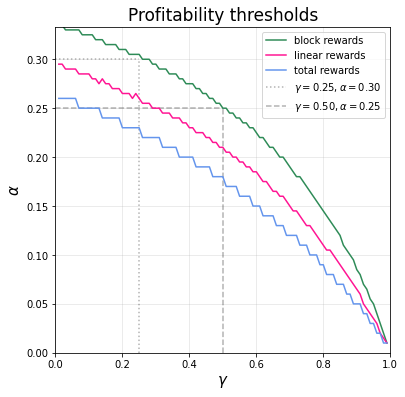

In [549]:
f, ax = plt.subplots(figsize=(6,6))

ax.plot(gammas, b_res, label='block rewards', color='seagreen')
ax.plot(gammas, l_res, label='linear rewards', color='deeppink')
ax.plot(gammas, f_res, label='total rewards', color='cornflowerblue')

ax.grid(alpha=0.3)
ax.set_xlabel(r'$\gamma$', size=15)
ax.set_ylabel(r'$\alpha$', size=15)
ax.set_title(r'Profitability thresholds', size=17)

ax.hlines(0.3, xmin=0, xmax=0.25, color='black', linestyles='dotted', alpha=0.3, 
          label=r'$\gamma=0.25,\alpha=0.30$')
ax.vlines(0.25, ymin=0, ymax=0.3, color='black', linestyles='dotted', alpha=0.3)
ax.hlines(0.25, xmin=0, xmax=0.5, color='black', linestyles='--', alpha=0.3, 
          label=r'$\gamma=0.50,\alpha=0.25$')
ax.vlines(0.5, ymin=0, ymax=0.25, color='black', linestyles='--', alpha=0.3)

ax.set_xlim(0,1)
ax.set_ylim(0,1/3)

ax.legend()
plt.savefig('out.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

# making it more efficient

In [699]:
gammas = np.arange(0.01, 1, 0.01)
alphas = np.arange(0.01, 0.50, 0.0025)
betas = np.arange(1.01, 5.01, 0.01)

In [700]:
p_ = 0.5
C_ = 1.

In [701]:
p1_ev = p1_sym.evalf(subs={C:1., E:1., p:0.5})
p1_ev

a*(-1.0*a*Min(1.0, 7.38905609893065*exp(-b)) + 2.0*a - 2.71828182845905*a*exp(-b) + 0.5*Min(1.0, 7.38905609893065*exp(-b)) - 1.0 + 1.35914091422952*exp(-b))/(-1.5*a**2*Min(1.0, 7.38905609893065*exp(-b)) + 3.0*a**2 - 4.07742274268857*a**2*exp(-b) + 1.0*a*Min(1.0, 7.38905609893065*exp(-b)) + 2.71828182845905*a*exp(-b) - 1.0)

In [702]:
honest_final_fixed   = honest_full_fixed.evalf(subs={p1:p1_ev, E:1., p:0.5, C:1.})
attacker_final_fixed = attacker_full_fixed.evalf(subs={p1:p1_ev, E:1., p:0.5, C:1.})
honest_final_bern    = honest_full_bern.evalf(subs={p1:p1_ev, E:1., p:0.5, C:1.})
attack_final_bern    = attack_full_bern.evalf(subs={p1:p1_ev, E:1., p:0.5, C:1.})
attack_final_lin     = attack_full_lin.evalf(subs={p1:p1_ev, E:1., p:0.5, C:1.})

In [703]:
br = sp.simplify(attacker_final_fixed/(attacker_final_fixed+honest_final_fixed))
br_lambda = sp.lambdify((a,b,g), br, 'numpy')
br_lambda = np.vectorize(br_lambda)
br_lambda

In [704]:
lin = sp.simplify(attack_final_lin)
lin_lambda = sp.lambdify((a,b,g), lin)
lin_lambda

<function _lambdifygenerated(a, b, g)>

In [705]:
bern = sp.simplify(attack_final_bern/(attack_final_bern+honest_final_bern))

In [713]:
full = (br + lin + bern)/3
full_lambda = sp.lambdify((a,b,g), full)

In [730]:
starting_alphas = np.linspace(0.25, 0.0, len(gammas))
starting_alphas = starting_alphas**(1/6)-0.57

In [709]:
b_res  = []
for i, g_ in tqdm(enumerate(gammas)):
    cand_alphas = alphas[alphas>starting_alphas[i]]
    for a_ in cand_alphas:
        br_lambda = np.vectorize(sp.lambdify((b), br.evalf(subs={a:a_, g:g_}), 'numpy'))
        bs = br_lambda(betas)
        bestBeta = betas[np.argmax(bs)]
        if full_lambda(a_, bestBeta, g_) > a_:
            b_res.append(a_)
            break
b_res = np.array(b_res)
b_res.shape

99it [02:03,  1.25s/it]


(99,)

In [710]:
l_res  = []
for i, g_ in tqdm(enumerate(gammas)):
    cand_alphas = alphas[alphas>starting_alphas[i]]
    for a_ in cand_alphas:
        lin_lambda = np.vectorize(sp.lambdify((b), lin.evalf(subs={a:a_, g:g_}), 'numpy'))
        bs = lin_lambda(betas)
        bestBeta = betas[np.argmax(bs)]
        if full_lambda(a_, bestBeta, g_) > a_:
            l_res.append(a_)
            break        
l_res = np.array(l_res)
l_res.shape

99it [01:18,  1.26it/s]


(99,)

In [732]:
f_res = []
for i, g_ in tqdm(enumerate(gammas)):
    cand_alphas = alphas[alphas>starting_alphas[i]]
    for a_ in cand_alphas:
        full_lambda_inner = np.vectorize(sp.lambdify((b), full.evalf(subs={a:a_, g:g_}), 'numpy'))
        bs = full_lambda_inner(betas)
        bestBeta = betas[np.argmax(bs)]
        if full_lambda(a_, bestBeta, g_) > a_:
            f_res.append(a_)
            break        
f_res = np.array(bl_res)
f_res.shape

99it [02:05,  1.27s/it]


(99,)

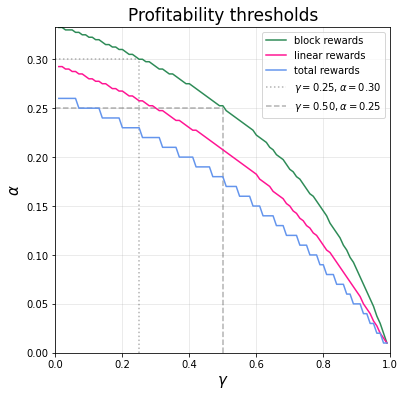

In [733]:
f, ax = plt.subplots(figsize=(6,6))

ax.plot(gammas, b_res, label='block rewards', color='seagreen')
ax.plot(gammas, l_res, label='linear rewards', color='deeppink')
ax.plot(gammas, f_res, label='total rewards', color='cornflowerblue')
# ax.plot(gammas, starting_alphas, label='total rewards', color='cornflowerblue')
# ax.plot(gammas, starting_alphas**(1/6)-0.57, label='total rewards', color='cornflowerblue')


ax.grid(alpha=0.3)
ax.set_xlabel(r'$\gamma$', size=15)
ax.set_ylabel(r'$\alpha$', size=15)
ax.set_title(r'Profitability thresholds', size=17)

ax.hlines(0.3, xmin=0, xmax=0.25, color='black', linestyles='dotted', alpha=0.3, 
          label=r'$\gamma=0.25,\alpha=0.30$')
ax.vlines(0.25, ymin=0, ymax=0.3, color='black', linestyles='dotted', alpha=0.3)
ax.hlines(0.25, xmin=0, xmax=0.5, color='black', linestyles='--', alpha=0.3, 
          label=r'$\gamma=0.50,\alpha=0.25$')
ax.vlines(0.5, ymin=0, ymax=0.25, color='black', linestyles='--', alpha=0.3)

ax.set_xlim(0,1)
ax.set_ylim(0,1/3)

ax.legend()
plt.savefig('out.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

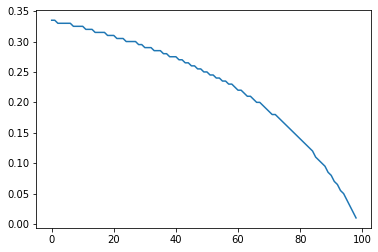

In [632]:
plt.plot(b_res)

In [494]:
honest_final_fixed_lambda   = sp.lambdify((a, b, p, g, C), honest_final_fixed)
attacker_final_fixed_lambda = sp.lambdify((a, b, p, g, C), attacker_final_fixed)
honest_final_bern_lambda    = sp.lambdify((a, b, p, g, C), honest_final_bern)
attacker_final_bern_lambda  = sp.lambdify((a, b, p, g, C), attacker_final_bern)
attack_final_lin_lambda     = sp.lambdify((a, b, p, g, C), attack_final_lin)
attack_final_lin_lambda

<function _lambdifygenerated(a, b, p, g, C)>

In [495]:
def BlockRewards(a_, b_, p_, g_, C_):
    a_fixed = attacker_final_fixed_lambda(a_, b_, p_, g_, C_)
    h_fixed = honest_final_fixed_lambda(a_, b_, p_, g_, C_)
    return a_fixed/(a_fixed+h_fixed)

def LinRewards(a_, b_, p_, g_, C_):
    return attack_final_lin_lambda(a_, b_, p_, g_, C_)

def LinAndBlockRewards(a_, b_, p_, g_, C_):
    lin  = attack_final_lin_lambda(a_, b_, p_, g_, C_)
    a_fixed = attacker_final_fixed_lambda(a_, b_, p_, g_, C_)
    h_fixed = honest_final_fixed_lambda(a_, b_, p_, g_, C_)
    return lin + a_fixed/(a_fixed+h_fixed)

def FullRewards(a_, b_, p_, g_, C_):
    lin  = attack_final_lin_lambda(a_, b_, p_, g_, C_)
    a_fixed = attacker_final_fixed_lambda(a_, b_, p_, g_, C_)
    h_fixed = honest_final_fixed_lambda(a_, b_, p_, g_, C_)
    a_bern  = attacker_final_bern_lambda(a_, b_, p_, g_, C_)
    h_bern  = honest_final_bern_lambda(a_, b_, p_, g_, C_)
    return (lin + a_fixed/(a_fixed+h_fixed) + a_bern/(a_bern+h_bern))/3

In [545]:
gammas = np.arange(0.01, 1, 0.01)
alphas = np.arange(0.01, 0.50, 0.005)
betas = np.arange(1.01, 5.01, 0.05)
p_ = 0.5
C_ = 1.

In [ ]:
p_ = 0.5
g_ = 0.1

In [508]:
a_ = 0.26

In [509]:
bs = [LinRewards(a_, b_, p_, g_, C_) for b_ in betas]
bestBeta = betas[np.argmax(bs)]
bestBeta, FullRewards(a_, bestBeta, p_, g_, C_)

(2.360000000000001, 0.2551061712501037)

In [510]:
bs = [FullRewards(a_, b_, p_, g_, C_) for b_ in betas]
bestBeta = betas[np.argmax(bs)]
bestBeta, FullRewards(a_, bestBeta, p_, g_, C_)

(1.8600000000000008, 0.26223290139728433)

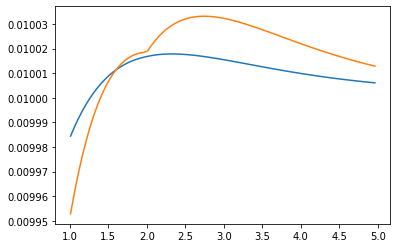

In [519]:
plt.plot(betas,[FullRewards(a_, b_, p_, g_, C_)for b_ in betas])
plt.plot(betas, [LinRewards(a_, b_, p_, g_, C_)for b_ in betas])

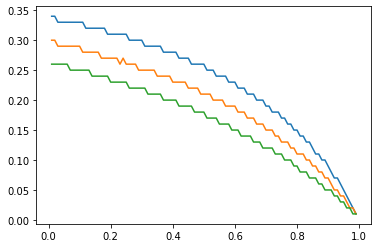

In [517]:
plt.plot(gammas, b_res)
plt.plot(gammas, l_res)
# plt.plot(gammas, bl_res)
plt.plot(gammas, f_res)